# Give me Attention!

Contributor: michaelmenzel@google.com

Various experiments which explore attention mechanisms and their influence on prediction accuracy and complexity.

In [18]:
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Attention

In [37]:
#q = tf.constant([[[1, 1], [1, 1]]], dtype=tf.float32)
q = k = v = tf.constant([
                         [[0.5, 0.2, 0.1], 
                          [0.3, 0.6, 0.5],
                          [0.4, 0.7, 0.3]]
                         ], dtype=tf.float32)
mask = tf.cast(tf.constant([[-100, -100, -100], 
                    [-100, 1, 1],
                    [-100, 1, 1]]), tf.float32)
[q, k, v]

[<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
 array([[[0.5, 0.2, 0.1],
         [0.3, 0.6, 0.5],
         [0.4, 0.7, 0.3]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
 array([[[0.5, 0.2, 0.1],
         [0.3, 0.6, 0.5],
         [0.4, 0.7, 0.3]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
 array([[[0.5, 0.2, 0.1],
         [0.3, 0.6, 0.5],
         [0.4, 0.7, 0.3]]], dtype=float32)>]

In [38]:
mask

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-100., -100., -100.],
       [-100.,    1.,    1.],
       [-100.,    1.,    1.]], dtype=float32)>

### Scaled Dot Product Attention

In [39]:
tf.linalg.matmul(q, k, transpose_b=True)

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[0.29999998, 0.32000002, 0.37      ],
        [0.32000002, 0.70000005, 0.69000006],
        [0.37      , 0.69000006, 0.74      ]]], dtype=float32)>

In [40]:
tf.linalg.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(tf.size(k), tf.float32))

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[0.09999999, 0.10666668, 0.12333333],
        [0.10666668, 0.23333335, 0.23000002],
        [0.12333333, 0.23000002, 0.24666667]]], dtype=float32)>

In [41]:
tf.linalg.matmul((tf.linalg.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(tf.size(k), tf.float32))), mask, transpose_b=True)

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[-33.       ,  -9.7699995,  -9.7699995],
        [-57.000008 , -10.203335 , -10.203335 ],
        [-60.000004 , -11.8566675, -11.8566675]]], dtype=float32)>

In [42]:
tf.nn.softmax(tf.linalg.matmul((tf.linalg.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(tf.size(k), tf.float32))), mask, transpose_b=True))

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[4.0767060e-11, 5.0000000e-01, 5.0000000e-01],
        [2.3737404e-21, 5.0000000e-01, 5.0000000e-01],
        [6.1742510e-22, 5.0000000e-01, 5.0000000e-01]]], dtype=float32)>

In [43]:
def scaled_dot_product_attention(q, k, v):
  d_k = tf.cast(tf.size(k), tf.float32)
  return tf.linalg.matmul(tf.nn.softmax(tf.linalg.matmul(q, k, transpose_b=True) / tf.math.sqrt(d_k)), v)

In [15]:
scaled_dot_product_attention(q, k, v)

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[0.        , 0.43333334, 0.26666668],
        [0.        , 0.46052033, 0.28401512],
        [0.        , 0.46014136, 0.28300965]]], dtype=float32)>

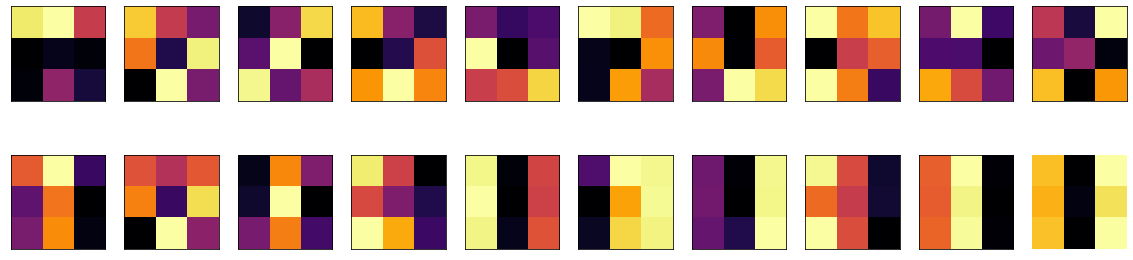

In [ ]:
test_images = [tf.random.uniform((3, 3)) for i in range(10)]

fig, axs = plt.subplots(nrows=2, ncols=len(test_images), figsize=(20, 5),
                        subplot_kw={'xticks': [], 'yticks': []})
for i in range(len(axs[0,:])):
  axs[0,i].imshow(test_images[i], cmap='inferno')
  axs[1,i].imshow(scaled_dot_product_attention(test_images[i], test_images[i], test_images[i]), cmap='inferno')
plt.axis('off')
plt.show()

### Multi-Head Attention

In [ ]:
def multi_head_attention(q, k, v, d_model):
  qw = tf.keras.layers.Dense(d_model, use_bias=False)(q)
  kw = tf.keras.layers.Dense(d_model, use_bias=False)(k)
  vw = tf.keras.layers.Dense(d_model, use_bias=False)(v)
  return tf.keras.layers.Dense(d_model, use_bias=False)(scaled_dot_product_attention(qw, kw, vw))


In [ ]:
multi_head_attention(q, k, v, 2)

<tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
array([[[-0.00208041,  0.20830968],
        [-0.01465899,  0.1277632 ]]], dtype=float32)>

### MNIST Attention

In [ ]:
mnist_train, mnist_test = tfds.load("mnist", split=["train", "test"], as_supervised=True)

mnist_train = mnist_train.map(lambda x, y: (tf.squeeze(x/255, axis=-1), y))
mnist_train_batched = mnist_train.batch(128).prefetch(tf.data.AUTOTUNE)
mnist_test = mnist_test.map(lambda x, y: (tf.squeeze(x/255, axis=-1), y))
mnist_test_batched = mnist_test.batch(128).prefetch(tf.data.AUTOTUNE)

mnist_train_batched

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### What does scaled dot product attention look like on MNIST?

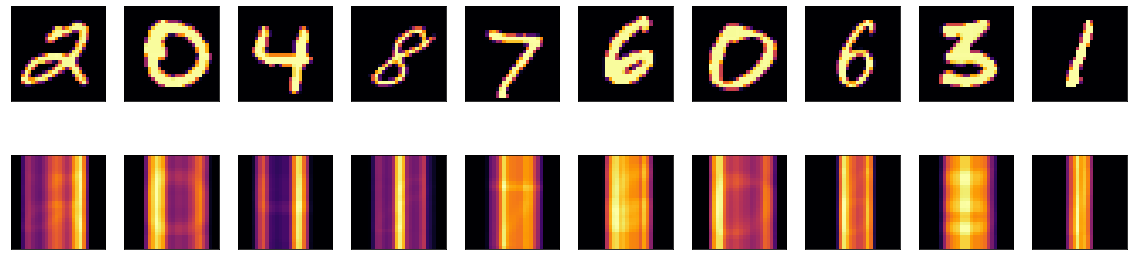

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(20, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, sample in enumerate(mnist_test.take(10)):
  axs[0,i].imshow(sample[0], cmap='inferno')
  axs[1,i].imshow(scaled_dot_product_attention(sample[0], sample[0], sample[0]), cmap='inferno')

fig.show()

In [ ]:
num_heads = 3
d_model = 28*num_heads

def build_model(with_mha=True, trainable_mlp=False):
  input = tf.keras.Input(shape=(28,28))

  if with_mha:
    mha = multi_head_attention(input, input, input, d_model)
    output_mha = tf.split(mha, num_heads, axis=-1, name='mha')
    flatten = tf.keras.layers.Flatten()(mha)
  else:
    output_mha = tf.ones_like(input, name='mha')
    flatten = tf.keras.layers.Flatten()(input)

  if trainable_mlp:
    output = tf.keras.layers.Dense(10, activation='softmax', name='class_one_hot')(flatten)
  else:
    output = tf.keras.layers.Dense(10, activation='softmax', name='class_one_hot', trainable=False, use_bias=False, kernel_initializer=tf.keras.initializers.Ones())(flatten)

  model = tf.keras.Model(inputs=input, outputs={'class_one_hot': output, 'mha': output_mha})
  model.summary()
  return model

def plot_test_sample(model, with_mha=True):
  mha_dims = num_heads if with_mha else 1
  fig, axs = plt.subplots(nrows=1+mha_dims, ncols=10, figsize=(20, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

  for i, sample in enumerate(mnist_test.batch(1).take(10)):
    axs[0,i].imshow(sample[0][0], cmap='inferno')
    predicted = model(sample[0])
    if with_mha:
      for j in range(num_heads):
        axs[1+j,i].imshow(predicted['mha'][j][0], cmap='inferno')
    else:
      axs[1,i].imshow(predicted['mha'][0], vmin=0, vmax=1, cmap='inferno')
    print(f'actual: {sample[1][0]}, predicted: {tf.argmax(predicted["class_one_hot"][0])}')

def run_experiment(with_mha=True, trainable_mlp=False, epochs=10):
  model = build_model(with_mha, trainable_mlp)
  mha_metrics = [None for i in range(num_heads)] if with_mha else None
  model.compile(optimizer='adam', 
                loss={'class_one_hot': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'mha':  lambda x,y: 0}, 
                metrics={'class_one_hot': tf.keras.metrics.SparseCategoricalAccuracy(), 'mha': mha_metrics})
  model.fit(mnist_train_batched, validation_data=mnist_test_batched, epochs=epochs)
  return model

#### Does multi-head attention learn?

In [ ]:
mha_only_model = run_experiment(epochs=3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 28, 84)       2352        ['input_1[0][0]']                
                                                                                                  
 tf.compat.v1.size (TFOpLambda)  ()                  0           ['dense_5[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 28, 84)       2352        ['input_1[0][0]']                
                                                                                              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


469/469 [==============================] - 9s 16ms/step - loss: 2.3026 - class_one_hot_loss: 2.3026 - tf.split_loss: 0.0000e+00 - class_one_hot_sparse_categorical_accuracy: 0.0987 - val_loss: 2.3026 - val_class_one_hot_loss: 2.3026 - val_tf.split_loss: 0.0000e+00 - val_class_one_hot_sparse_categorical_accuracy: 0.0980
Epoch 2/3
469/469 [==============================] - 4s 7ms/step - loss: 2.3026 - class_one_hot_loss: 2.3026 - tf.split_loss: 0.0000e+00 - class_one_hot_sparse_categorical_accuracy: 0.0987 - val_loss: 2.3026 - val_class_one_hot_loss: 2.3026 - val_tf.split_loss: 0.0000e+00 - val_class_one_hot_sparse_categorical_accuracy: 0.0980
Epoch 3/3
469/469 [==============================] - 3s 7ms/step - loss: 2.3026 - class_one_hot_loss: 2.3026 - tf.split_loss: 0.0000e+00 - class_one_hot_sparse_categorical_accuracy: 0.0987 - val_loss: 2.3026 - val_class_one_hot_loss: 2.3026 - val_tf.split_loss: 0.0000e+00 - val_class_one_hot_sparse_categorical_accuracy: 0.0980


actual: 2, predicted: 0
actual: 0, predicted: 0
actual: 4, predicted: 0
actual: 8, predicted: 0
actual: 7, predicted: 0
actual: 6, predicted: 0
actual: 0, predicted: 0
actual: 6, predicted: 0
actual: 3, predicted: 0
actual: 1, predicted: 0


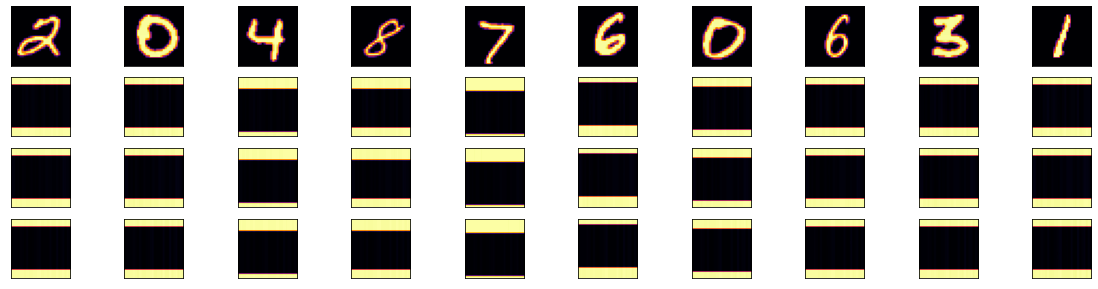

In [ ]:
plot_test_sample(mha_only_model)

#### Does multi-head attention help to learn?

We get a baseline with a single-layer MLP:

In [ ]:
mlp_model = run_experiment(with_mha=False, trainable_mlp=True, epochs=20)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_2[0][0]']                
                                                                                                  
 class_one_hot (Dense)          (None, 10)           7850        ['flatten_1[0][0]']              
                                                                                                  
 tf.ones_like (TFOpLambda)      (None, 28, 28)       0           ['input_2[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


469/469 [==============================] - 3s 7ms/step - loss: 0.6857 - class_one_hot_loss: 0.6857 - tf.ones_like_loss: 0.0000e+00 - class_one_hot_sparse_categorical_accuracy: 0.8263 - val_loss: 0.3872 - val_class_one_hot_loss: 0.3872 - val_tf.ones_like_loss: 0.0000e+00 - val_class_one_hot_sparse_categorical_accuracy: 0.8993
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3649 - class_one_hot_loss: 0.3649 - tf.ones_like_loss: 0.0000e+00 - class_one_hot_sparse_categorical_accuracy: 0.9003 - val_loss: 0.3215 - val_class_one_hot_loss: 0.3215 - val_tf.ones_like_loss: 0.0000e+00 - val_class_one_hot_sparse_categorical_accuracy: 0.9117
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3212 - class_one_hot_loss: 0.3212 - tf.ones_like_loss: 0.0000e+00 - class_one_hot_sparse_categorical_accuracy: 0.9110 - val_loss: 0.2981 - val_class_one_hot_loss: 0.2981 - val_tf.ones_like_loss: 0.0000e+00 - val_class_one_hot_sparse_categorical_accuracy: 0.91

actual: 2, predicted: 2
actual: 0, predicted: 0
actual: 4, predicted: 4
actual: 8, predicted: 8
actual: 7, predicted: 7
actual: 6, predicted: 6
actual: 0, predicted: 0
actual: 6, predicted: 6
actual: 3, predicted: 3
actual: 1, predicted: 1


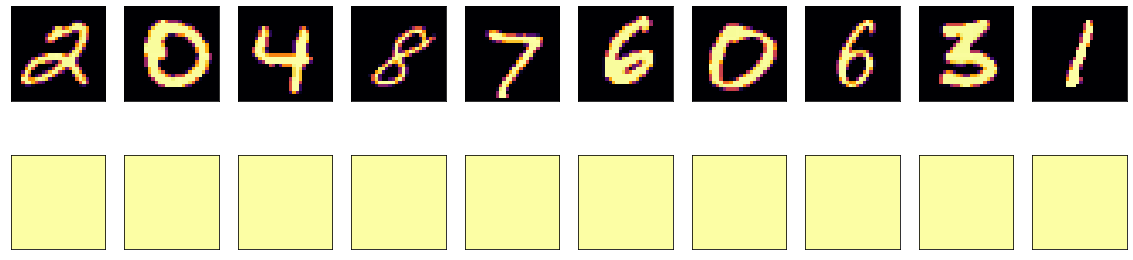

In [ ]:
plot_test_sample(mlp_model, with_mha=False)

#### How does multi-head attention improve learning?

In [ ]:
mha_model = run_experiment(with_mha=True, trainable_mlp=True, epochs=30)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 28, 84)       2352        ['input_3[0][0]']                
                                                                                                  
 tf.compat.v1.size_1 (TFOpLambd  ()                  0           ['dense_9[0][0]']                
 a)                                                                                               
                                                                                                  
 dense_8 (Dense)                (None, 28, 84)       2352        ['input_3[0][0]']          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


469/469 [==============================] - 5s 9ms/step - loss: 1.5382 - class_one_hot_loss: 1.5382 - tf.split_1_loss: 0.0000e+00 - class_one_hot_sparse_categorical_accuracy: 0.4744 - val_loss: 0.7938 - val_class_one_hot_loss: 0.7938 - val_tf.split_1_loss: 0.0000e+00 - val_class_one_hot_sparse_categorical_accuracy: 0.7614
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 0.6662 - class_one_hot_loss: 0.6662 - tf.split_1_loss: 0.0000e+00 - class_one_hot_sparse_categorical_accuracy: 0.8049 - val_loss: 0.5692 - val_class_one_hot_loss: 0.5692 - val_tf.split_1_loss: 0.0000e+00 - val_class_one_hot_sparse_categorical_accuracy: 0.8281
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 0.5482 - class_one_hot_loss: 0.5482 - tf.split_1_loss: 0.0000e+00 - class_one_hot_sparse_categorical_accuracy: 0.8397 - val_loss: 0.5027 - val_class_one_hot_loss: 0.5027 - val_tf.split_1_loss: 0.0000e+00 - val_class_one_hot_sparse_categorical_accuracy: 0.8460
Epoch 4/3

actual: 2, predicted: 2
actual: 0, predicted: 0
actual: 4, predicted: 3
actual: 8, predicted: 1
actual: 7, predicted: 7
actual: 6, predicted: 6
actual: 0, predicted: 0
actual: 6, predicted: 8
actual: 3, predicted: 5
actual: 1, predicted: 1


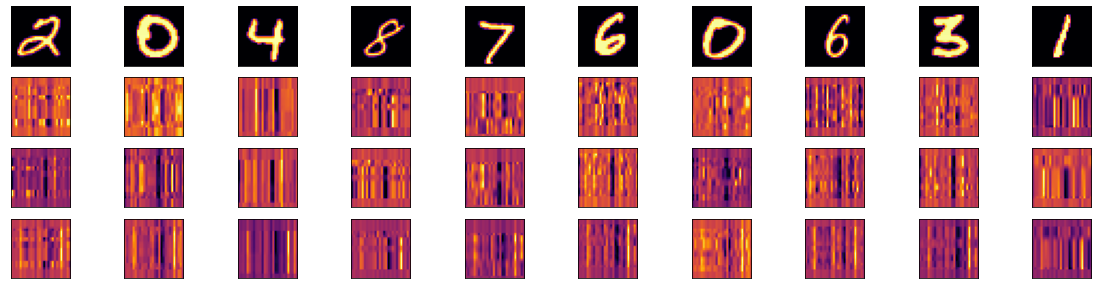

In [ ]:
plot_test_sample(mha_model)